### Importing libraries and setting up directories to prepare data for preprocess.py script

We need landsat images and labels to cover the same extent in order to pass the data tot he preprocess pipeline and then to the model. This notebook steps through the functions necessary to munge labels to fit the Landsat tile extent of interest. More work will need to be done to prepare data across multiple tiles for MaskRCNN.

In [1]:
import os
import sys
import random
import numpy as np
import skimage.io as skio
import matplotlib
import matplotlib.pyplot as plt
import copy
from skimage import measure
import rasterio
import rasterio.features
import rasterio.warp
import geopandas as gpd
import shapely as shp
from shapely.geometry import Polygon
import rasterio
import rasterio.env
%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/rave/tana-crunch/waves/cropmask/data/")

TILE_LABELS_DIR = os.path.join(ROOT_DIR, 'tile_labels')
# first run for f in *; do tar -zxvf $f -C ./ && rm $f; done
# if in .tar.gz 
ORIGINAL_LABELS_DIR = os.path.join(ROOT_DIR, 'original_nebraska_labels')
LANDSAT_ARCHIVE_DIR = os.path.join(ROOT_DIR, 'North_Platte_Western_NB_L5_2004-2006')
LANDSAT_STACKED_DIR = os.path.join(ROOT_DIR, 'North_Platte_Western_NB_L5_2004-2006_stacked') # directory of Landsat imgs where bands for an acquisition in one tif

try:
    os.mkdir(ORIGINAL_LABELS_DIR)
    os.mkdir(LANDSAT_ARCHIVE_DIR)
    os.mkdir(LANDSAT_STACKED_DIR)
    os.mkdir(TILE_LABELS_DIR)
except:
    FileExistsError

os.chdir(ROOT_DIR)

In [4]:
def tile_label_intersect(directory, path_row, epsg_string='EPSG:32613'):
    """
    Finds the intersection of a large labels shapefile with a Landsat tile and
    potentially other raster sources, Useful when label datasets are used that weren't
    originally digitized from the Landsat tile and have different extents.
    Runs slow due to badly optimized GeoDataFrame code as intersection engine.
    """

In [5]:
def raster_to_polygon(directory, path_row, epsg_string='EPSG:32613'):
    """
    Finds the extent of a raster (the valid data extent not the bbox) and
    returns as a shapely polygon.
    """
    bands = os.listdir(directory)
    scenes_list = [b for b in bands if path_row in b] 
    #get an example raster of the path/row of interest to get data extent
    with rasterio.open(os.path.join(directory, scenes_list[0])) as dataset:
        mask = dataset.dataset_mask()
    # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):
            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            if val == 255:
                geom = rasterio.warp.transform_geom(
                    dataset.crs, epsg_string, geom, precision=12)
    return Polygon(geom['coordinates'][1]) # 0th element is the bbox

In [32]:
polygon_032031 = raster_to_polygon(LANDSAT_ARCHIVE_DIR, "032031")
polygon_033031 = raster_to_polygon(LANDSAT_ARCHIVE_DIR, "033031")

In [34]:
pivots_df = gpd.read_file(os.path.join(ORIGINAL_LABELS_DIR,"AnalyzedPivots_GM.shp"))
pivots_df.to_crs(epsg=32613, inplace=True)


In [37]:
def intersect_polygon_multipolygons(df, polygon):
    """
    intersects a df of labels and a polygon of a raster tile and
    returns a df containing the label geometries that intersect
    """
    
    geodf = gpd.GeoDataFrame()
    for i in range(0, df['ObjectID'].count()): # need to make a row entry for each cp to do intersection (super inefficient)
        geodf.loc[i,'geometry'] = polygon
    return df[df.intersects(geodf)]

In [38]:
labels__032031 = intersect_polygon_multipolygons(pivots_df, polygon_032031)
labels__033031 = intersect_polygon_multipolygons(pivots_df, polygon_033031)

In [42]:
labels__032031.to_file(filename=os.path.join(TILE_LABELS_DIR,"2005_032031_labels.geojson"), driver="GeoJSON")
labels__033031.to_file(filename=os.path.join(TILE_LABELS_DIR,"2005_033031_labels.geojson"), driver="GeoJSON")

These tiles have  a lot of overlap, only using a single full tile for the preprocessing/modeling

Exception ignored in: <bound method Collection.__del__ of <open Collection '/home/rave/tana-crunch/waves/cropmask/data/tile_labels/2005_032031_labels.geojson:OgrGeoJSON', mode 'w' at 0x7ff9f7b21358>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/fiona/collection.py", line 426, in __del__
    self.close()
  File "/opt/anaconda3/lib/python3.6/site-packages/fiona/collection.py", line 403, in close
    self.flush()
  File "/opt/anaconda3/lib/python3.6/site-packages/fiona/collection.py", line 393, in flush
    self.session.sync(self)
  File "fiona/ogrext.pyx", line 1082, in fiona.ogrext.WritingSession.sync
ValueError: Null data source


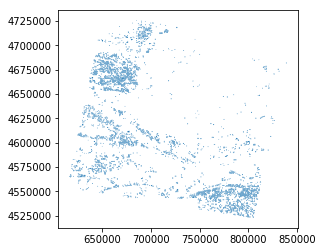

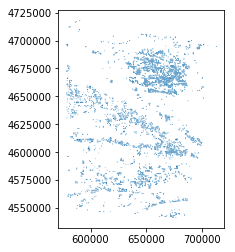

In [43]:
labels__032031.plot() # full scene, good
labels__033031.plot()

In [23]:
def scene_ids_from_bands_list(directory):
    bands = os.listdir(LANDSAT_ARCHIVE_DIR)
    for i,b in enumerate(bands):
        bands[i] = b[0:37]
    scenes = np.unique(bands)
    return scenes

In [84]:
def stack_and_save_rgb_rasterio(src_directory, dst_directory):
    """
    To expand this to stack more bands, need to abstract the if 
    band statements and appended string
    """
    bands = sorted(os.listdir(src_directory))
    scenes = scene_ids_from_bands_list(src_directory)
    with rasterio.Env():
        for scene in scenes:
            # gets list of bgr file names
            bgr = [os.path.join(src_directory,band) for band in [band for band in bands if scene in band] if "band1" in band or "band2" in band or "band3" in band]
            rgb_scene = np.stack([skio.imread(bgr[0]),skio.imread(bgr[1]),skio.imread(bgr[2])], axis=0)
            src = rasterio.open(bgr[0])
            profile = src.profile.copy()
            profile.update(count=3)
            with rasterio.open(os.path.join(dst_directory,scene+'_rgb.tif'), 'w', **profile) as dst:
                dst.write(rgb_scene)
stack_and_save_rgb_rasterio(LANDSAT_ARCHIVE_DIR, LANDSAT_STACKED_DIR)

In [ ]:
def load_merge_landsat(image_id, source_dir):
    """Load the landsat bands and returns a [H,W,3] 
    Numpy array. Channels are ordered [B, G, R]
    https://landsat.usgs.gov/what-are-band-designations-landsat-satellites
    """
    # Load image
    os_path = source_dir+'/'+image_id+'_MS_OS.tif'
    gs_path = source_dir+'/'+image_id+'_MS_GS.tif'
    os_image = skio.imread(os_path)
    gs_image = skio.imread(gs_path)
    # If has more than 4 bands, select correct bands 
    # will need to provide image config in future
    # to programmaticaly use correct band mappings
    if os_image.shape[-1] != 4:
        os_image = np.dstack((os_image[:,:,1:3],os_image[:,:,4],os_image[:,:,6]))
    if gs_image.shape[-1] != 4:
        gs_image = np.dstack((gs_image[:,:,1:3],gs_image[:,:,4],gs_image[:,:,6]))
    stacked_image = np.dstack((os_image, gs_image))
    stacked_image_path = EIGHTCHANNEL_DIR +'/'+ image_id + '_OSGS_ms.tif'
    assert stacked_image.ndim == 3
    if -1.7e+308 not in stacked_image:
        #removes partial grids
        skio.imsave(stacked_image_path,stacked_image, plugin='tifffile')
    else:
        #might try later, keeps partial grids and sets nodata to 0
        # but no examples i've seen use partial images for training like this commented code
        #stacked_image[stacked_image==-1.7e+308]=0
        #skio.imsave(stacked_image_path,stacked_image, plugin='tifffile')
# all files, including ones we don't care about
file_ids_all = next(os.walk(WV2_DIR))[2]
# all multispectral on and off season tifs
image_ids_all = [image_id for image_id in file_ids_all if 'MS' in image_id]
#check for duplicates
assert len(image_ids_all) == len(set(image_ids_all))

image_ids_gs = [image_id for image_id in image_ids_all if 'GS' in image_id]
image_ids_os = [image_id for image_id in image_ids_all if 'OS' in image_id]

#check for equality
assert len(image_ids_os) == len(image_ids_gs)

image_ids_short = [image_id[0:9] for image_id in image_ids_gs]

for imid in image_ids_short:
    load_merge_wv2(imid, WV2_DIR)

In [ ]:
def show_arr(image_id):
    """Load the specified wv2 os/gs image pairs and return a [H,W,8] 
    Numpy array. Channels are ordered [B, G, R, NIR, B, G, R, NIR], OS 
    first.
    """

    stacked_image_path = EIGHTCHANNEL_DIR +'/'+ image_id + '_OSGS_ms.tif'

    arr = skio.imread(stacked_image_path, plugin='tifffile')
    
    plt.figure()
    arr[arr==-1.7e+308]=0
    skio.imshow(arr[:,:,0])
    plt.title(str(np.min(arr))+' '+stacked_image_path)
    return arr
# for imid in image_ids_short:
#     arr = show_arr(imid)

In [ ]:
image_list = next(os.walk(EIGHTCHANNEL_DIR))[2]
def move_img_to_folder(filename):
    '''Moves a file with identifier pattern ZA0165086_MS_GS.tif to a 
    folder path ZA0165086/image/ZA0165086_MS_GS.tif
    Also creates a masks folder at ZA0165086/masks'''
    
    folder_name = os.path.join(TRAIN_DIR,filename[:9])
    os.mkdir(folder_name)
    new_path = os.path.join(folder_name, 'image')
    mask_path = os.path.join(folder_name, 'masks')
    os.mkdir(new_path)
    file_path = os.path.join(EIGHTCHANNEL_DIR,filename)
    os.rename(file_path, os.path.join(new_path, filename))
    os.mkdir(mask_path)
    
for img in image_list:
    move_img_to_folder(img)
print('done moving images')

### Erosion/Dilation to get rid of really small partial fields created due to edge effects

In [ ]:
label_list = next(os.walk(LABELS_DIR))[2]

In [ ]:
from skimage import morphology as skim
for name in label_list:
    arr = skio.imread(os.path.join(LABELS_DIR,name))
    arr[arr == -1.7e+308]=0
    label_name = name[0:15]+'.tif'
    opened_path = os.path.join(OPENED_LABELS_DIR,name)
    kernel = np.ones((5,5))
    arr = skim.binary_opening(arr, kernel)
    arr=1*arr
    assert arr.ndim == 2
    skio.imsave(opened_path, 1*arr)

### Connected Components on wv2 labels, move them to connected comps folder

Does keeping no data from partial grid coverage lead to too much edge effects?
Should the arrays be opened before saved as seperate masks? The degree to which they are is a tuning param. 

In [ ]:
label_list = next(os.walk(OPENED_LABELS_DIR))[2]

In [ ]:
for name in label_list:
    arr = skio.imread(os.path.join(OPENED_LABELS_DIR,name))
    blob_labels = measure.label(arr, background=0)
    print(blob_labels.shape, 'blob')
    blob_vals = np.unique(blob_labels)
    for blob_val in blob_vals[blob_vals!=0]:
        labels_copy = blob_labels.copy()
        labels_copy[blob_labels!=blob_val] = 0
        labels_copy[blob_labels==blob_val] = 1
        label_name = name[0:15]+str(blob_val)+'.tif'
        label_path = os.path.join(CONNECTED_COMP_DIR,label_name)
        print(labels_copy.shape, 'copy')
        assert labels_copy.ndim == 2
        skio.imsave(label_path, labels_copy)

In [ ]:
def move_mask_to_folder(filename):
    '''Moves a mask with identifier pattern ZA0165086_label_1.tif to a 
    folder path ZA0165086/mask/ZA0165086_label_01.tif. Need to run 
    connected components first.
    '''
    if os.path.isdir(os.path.join(TRAIN_DIR,filename[:9])):
        folder_path = os.path.join(TRAIN_DIR,filename[:9])
        mask_path = os.path.join(folder_path, 'masks')
        file_path = os.path.join(CONNECTED_COMP_DIR,filename)
        os.rename(file_path, os.path.join(mask_path, filename))
    
mask_list = next(os.walk(CONNECTED_COMP_DIR))[2]
for mask in mask_list:
    move_mask_to_folder(mask)
print('Done moving masks')

### After masks are moved, run np.zeros_like to create empty mask from image for folders only where there is no mask. Keras expects mask for each image even if there are no instances. There are over 300 out of 794 grids without any fields, could lead to big class imbalance

In [ ]:
import pandas as pd
id_list = next(os.walk(TRAIN_DIR))[1]
no_field_list = []
for fid in id_list:
    mask_folder = os.path.join('train',fid, 'masks')
    if not os.listdir(mask_folder): 
        no_field_list.append(mask_folder)
no_field_frame = pd.DataFrame(no_field_list)
no_field_frame.to_csv('no_field_list.csv')

In [ ]:
import shutil
for fid in id_list:
    mask_folder = os.path.join(ROOT_DIR,'train',fid, 'masks')
    im_folder = os.path.join(ROOT_DIR,'train',fid, 'image')
    if not os.listdir(mask_folder): 
        im_path = os.path.join(im_folder, os.listdir(im_folder)[0])
        arr = skio.imread(im_path)
        mask = np.zeros_like(arr[:,:,0])
        print(mask.shape)
        assert mask.ndim == 2
        skio.imsave(os.path.join(mask_folder, fid + '_label_0.tif'),mask)
        shutil.rmtree(os.path.join('train',fid)) #removing no field images

Calculating mean pixel across all grids for each channel, ignoring nans

In [ ]:
def get_arr_channel_mean(channel):
    means = []
    for i, fid in enumerate(id_list):
        im_folder = os.path.join('train',fid, 'image')
        im_path = os.path.join(im_folder, os.listdir(im_folder)[0])
        arr = skio.imread(im_path)
        arr[arr==-1.7e+308]=np.nan
        means.append(np.nanmean(arr[:,:,channel]))
    return np.mean(means)
print(get_arr_channel_mean(0))
print(get_arr_channel_mean(1))
print(get_arr_channel_mean(2))
print(get_arr_channel_mean(3))
print(get_arr_channel_mean(4))
print(get_arr_channel_mean(5))
print(get_arr_channel_mean(6))
print(get_arr_channel_mean(7))


Plotting connected components

In [ ]:
testdir = os.path.join(ROOT_DIR,'train/ZA0953012/masks')
labs = next(os.walk(testdir))[2]
os.chdir(testdir)
for path in labs:
    arr = skio.imread(path)
    all_labels = measure.label(arr)
    plt.figure(figsize=(9, 3.5))
    plt.subplot(131)
    plt.imshow(arr, cmap='gray')
    plt.title(path)
    plt.tight_layout()
    plt.show()

In [ ]:
os.chdir(LABELS_DIR)
for path in label_list[0:50]:
    arr = skio.imread(path)
    arr[arr == -1.7e+308]=0
    all_labels = measure.label(arr)
    blob_labels = measure.label(arr, background=0)
    plt.figure(figsize=(9, 3.5))
    plt.subplot(131)
    plt.imshow(arr, cmap='gray')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(all_labels, cmap='spectral')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(blob_labels, cmap='spectral')
    plt.axis('off')
    plt.title(path)
    plt.tight_layout()
    plt.show()

Does keeping no data from partial grid coverage lead to too much edge effects?

In [ ]:
arr[arr == -1.7e+308]=0

In [ ]:
np.unique(arr)